# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 100
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 0.001
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


In [5]:
dataset_size = len(train_set)
testdata_size = len(test_set)
print("CIFAR-10 训练集的大小:", dataset_size)
print("CIFAR-10 测试集的大小:", testdata_size)

CIFAR-10 训练集的大小: 50000
CIFAR-10 测试集的大小: 10000


### Model

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [8]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=0.5, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, target):
        ce_loss = F.cross_entropy(logits, target, reduction='none')
        p = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - p) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

criterion = FocalLoss()

In [10]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    model.train()
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

In [11]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

### Model Training

In [12]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0213 Acc: 0.1492
Begin test......
Test Loss: 0.0195 Acc: 0.2513
Epoch: 2/30 Train Loss: 0.0182 Acc: 0.2800
Begin test......
Test Loss: 0.0167 Acc: 0.3438
Epoch: 3/30 Train Loss: 0.0167 Acc: 0.3351
Begin test......
Test Loss: 0.0154 Acc: 0.3898
Epoch: 4/30 Train Loss: 0.0158 Acc: 0.3623
Begin test......
Test Loss: 0.0146 Acc: 0.4122
Epoch: 5/30 Train Loss: 0.0153 Acc: 0.3864
Begin test......
Test Loss: 0.0140 Acc: 0.4375
Epoch: 6/30 Train Loss: 0.0149 Acc: 0.4006
Begin test......
Test Loss: 0.0139 Acc: 0.4430
Epoch: 7/30 Train Loss: 0.0147 Acc: 0.4088
Begin test......
Test Loss: 0.0138 Acc: 0.4489
Epoch: 8/30 Train Loss: 0.0146 Acc: 0.4163
Begin test......
Test Loss: 0.0136 Acc: 0.4561
Epoch: 9/30 Train Loss: 0.0143 Acc: 0.4240
Begin test......
Test Loss: 0.0133 Acc: 0.4652
Epoch: 10/30 Train Loss: 0.0142 Acc: 0.4312
Begin test......
Test Loss: 0.0132 Acc: 0.4717
Epoch: 11/30 Train Loss: 0.0141 Acc: 0.4361
Begin test......
Test Loss: 0.0130 Acc: 0.4779
Epoch: 1

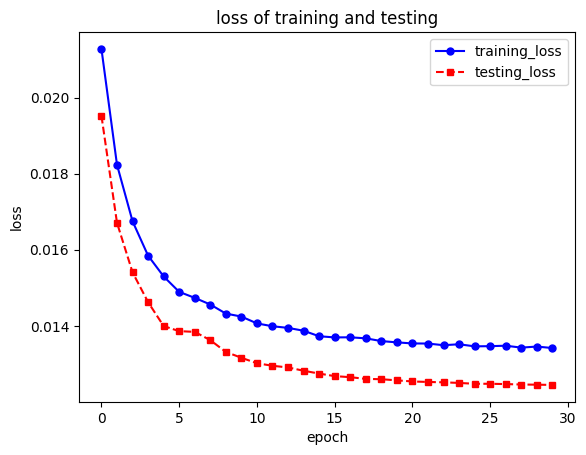

In [15]:
plt.plot(training_loss, label='training_loss', color='b', marker='o', linestyle='-',markersize=5)

# 添加第二根线
plt.plot(testing_loss, label='testing_loss', color='r', marker='s', linestyle='--',markersize=5)

# 添加标签和标题
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss of training and testing")

# 添加图例
plt.legend(loc='upper right')

plt.savefig("loss_Focal$1$0.5_0.001_50.png",dpi=600)
# 显示图形
plt.show()

In [ ]:
plt.plot(training_acc, label='training_acc', color='orange', marker='o', linestyle='-',markersize=5)

# 添加第二根线
plt.plot(testing_acc, label='testing_acc', color='g', marker='s', linestyle='--',markersize=5)

# 添加标签和标题
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("accuracy of training and testing")

# 添加图例
plt.legend(loc='lower right')
plt.savefig("accuracy_Focal$1$0.5_0.001_30.png",dpi=600)
# 显示图形
plt.show()